<center>
    <h2>Computational Statistics <br> Extension de l'algorithme SAEM pour des données manquantes </h2> 08 / 12 / 2023<br> Prof. Stéphanie Allassonnière <br>
 <br> <br>
Vincent Herfeld, Simon Queric
</center>


### Modèle non linéaire à effets mixtes

On observe la charge virale de $N$ individus sur une certaine période : 

\begin{equation*}
    \begin{cases}
        y_{i,j} &= f(\phi_i, t_{i,j}) + \varepsilon_{i,j} \\
        \varepsilon_{i,j} &\sim \mathcal{N}(0, \sigma^2 I_n) \\
        \phi_i &= \mu + b_i, b_i \sim \mathcal{N}(0, \Omega)
    \end{cases}
\end{equation*}

De plus, on suppose que lorsqu'une mesure $y_{i,j}$ est en dessous d'un seuil $LOQ$, la valeur n'est pas réellement observée.

La log-vraissemblance des données (observées et non observées) s'écrit : 

\begin{equation*}
    \begin{aligned}
    \log{p(y, \phi, \theta)} &= \log{p(y, \theta \mid \phi)} + \log{p(\phi)} \\
                             &= - NK\log{\sigma} + \sum_{i=1}^N\sum_{j=1}^K{-\frac{(y_{i,j} - f(\phi_i, t_{i,j}))^2}{2\sigma^2}} \\
                             & + \sum_{i=1}^N{-\frac{(\phi_i-\mu)^T\Omega^{-1}(\phi_i - \mu)}{2}} - N\log\det{\Omega}/2
    \end{aligned}
\end{equation*}

Les données manquantes sont les données de $z=(\phi, y^{cens})$  et les paramètres sont $\theta = ( \log{P_1}, \log{P_2}, \log{\lambda_1}, \log{\lambda_2}, \Omega, \sigma^2) = (\mu, \Omega, \sigma^2)$. 

$\Omega =\begin{pmatrix} \omega^2_1 & 0 & 0 & 0 \\ 0 & \omega^2_2 & 0 & 0 \\ 0 & 0 & \omega^2_3 & 0 \\ 0 & 0 & 0 & \omega^2_4 \end{pmatrix}$


Cette log-vraissemblance appartient à la famille des modèles exponentiels courbes.

En effet, on peut la réecrire sous la forme : 

\begin{equation*}
    \log{p(y, \phi, \theta)} = -\Lambda(\theta) + \langle S(y, z), \varphi(\theta) \rangle
\end{equation*}

où 


\begin{cases}
\displaystyle
\Lambda(\theta) &= NK\log{\sigma} + N\log\det\Omega + N\mu^T\Omega^{-1}\mu/2\\
\varphi(\theta) &= (\mu^T (\omega_1^{-2}, \omega_2^{-2}, \omega_3^{-2}, \omega_4^{-2}), -(\omega_1^{-2}, \omega_2^{-2}, \omega_3^{-2}, \omega_4^{-2})/2, -1/2\sigma^2)^T\\ 
S(y, z) &= \left(\sum_{i=1}^N{\phi_i}, \sum_{i=1}^N{\phi_i^2, \sum_{i,j}{(y_{i,j} - f(\phi_i, t_{i,j})^2)}}\right) \\
\end{cases}


La fonction $f$ qui modélise la décroissance de la charge virale est définie par :

$$ f(\phi, t) = \log_{10}{(P_{1}e^{-\lambda_1 t} + P_{2}e^{-\lambda_2 t})} $$

Il s'agit d'un modèle bi-exponentiel, modèle proposé par [?]. 

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [280]:
@jit(nopython=True)
def f(phi, i, t) :
    return np.log10(np.exp(phi[i, 0] - np.exp(phi[i, 2])*t) + np.exp(phi[i, 1] - np.exp(phi[i, 3])*t))

In [281]:
def generate_data(mu, Omega, sigma2=0.065**2, N=40, t=np.array([1, 3, 7, 14, 28, 56])) :
    n = len(t)
    y = np.zeros((N, n))
    b = np.random.multivariate_normal(mean=np.zeros_like(mu), cov=np.diag(Omega), size=(N))
    phi = mu + b
    eps = np.random.multivariate_normal(mean=np.zeros(n), cov=sigma2*np.eye(n), size=(N))
    for i in range(N) : 
        y[i] = f(phi, i, t)
    y = y + eps
    return y, phi

[12.2         7.8        -0.69314718 -2.99573227]


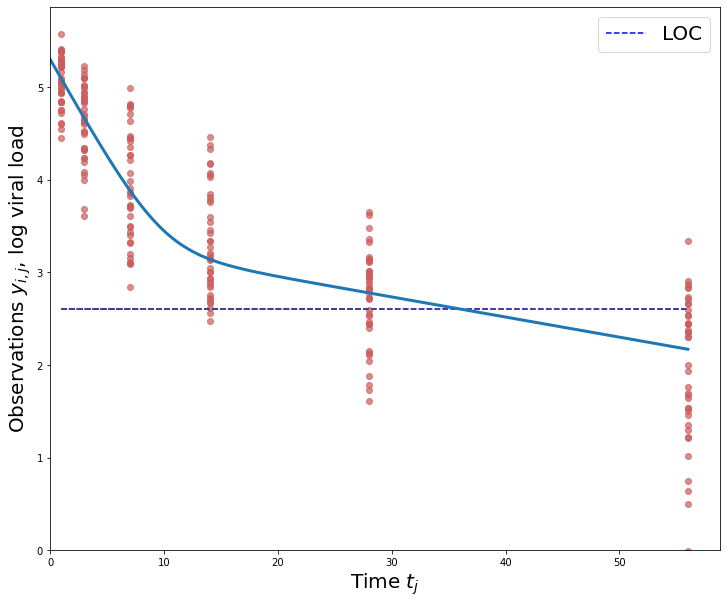

In [323]:
t = np.array([1, 3, 7, 14, 28, 56]) #np.arange(0, 7)
K = len(t)
mu = np.array([12.2, 7.8, np.log(0.5), np.log(0.05)])
print(mu)
omega2 = 0.3*np.ones(4)
sigma2 = 0.065**2
N = 40
LOC = np.log10(400) # 2.6
y, phi_true = generate_data(mu=mu, Omega=omega, sigma2=sigma2, N=N, t=t)
I = np.zeros((N, K))
I[y<=LOC] = 1 # 1 if censored else 0
k = len(y[0])
fig = plt.figure(figsize=(12, 10))
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
#plt.plot(t, y_mean, "k")
x = np.linspace(0, 56, 200)
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="blue", label="LOC")
for n in range(N) :
    plt.plot(t, y[n,:], alpha=0.7, color="indianred", ls=" ", marker='o')
#plt.plot(t, y_mean, "k")
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="darkslateblue", label="LOC")
#plt.fill_between(t, y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")

plt.plot(x, np.log10(np.exp(mu[0] - np.exp(mu[2])*x) + np.exp(mu[1] - np.exp(mu[3])*x)), lw=3)
plt.legend(["LOC"], fontsize=20)
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$, log viral load", fontsize=20)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

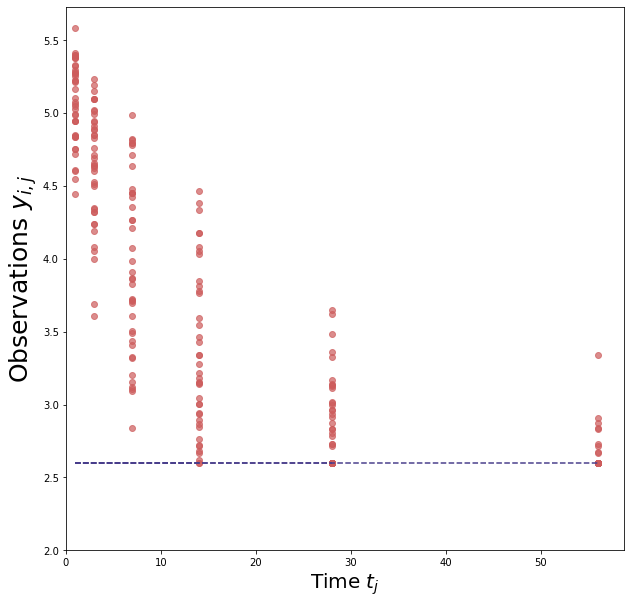

In [324]:
y_truncated = y*(y>=LOC) + LOC*(y<LOC)
fig = plt.figure(figsize=(10, 10))
for n in range(N) :
    plt.plot(t, y_truncated[n,:], alpha=0.7, color="indianred", ls=" ", marker='o')
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$", fontsize=25)
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="darkslateblue", label="LOC")

plt.ylim(ymin=2)
plt.xlim(xmin=0)
plt.show()

## Algorithme SAEM

### Initialisation 

Initialisation de $\widehat{\theta}_0$.

### Étape SAE

1. Simulation de $z^{(m)} = (\phi^{(m)}, y_{cens}^{(m)})$

2. $s_m = s_m + \gamma_m(S(y, z^{(m)}) - s_{m-1})$

### Étape M

Calcule de $\widehat{\theta}_m = \underset{\theta\in \Theta}{\text{argmax}} \left( -\Lambda(\theta) + \langle s_m, \varphi(\theta) \rangle \right) $

\begin{cases}
\widehat{\mu}_m &= \frac{1}{N}s_m^{(1)} \\
\widehat{\omega^2}_m &= \frac{1}{dN}\sum_{i=1}^N{(\phi_i-\widehat{\mu}_m)^T(\phi_i-\widehat{\mu}_m)} \\
\widehat{\sigma^2}_m &= \frac{1}{NK}s_m^{(3)}\\ 
\end{cases}

## Algorithme de Gibbs pour simuler les données manquantes

À l'étape $m$ de l'algorithme SAEM, on simule $z^{(m)} \sim p(\cdot \mid y_{obs}, \widehat{\theta}_{m-1})$ en deux étapes : 
1. $\phi^{(m)} \sim p(\cdot \mid y_{obs}, y^{(m-1)}_{cens}, \widehat{\theta}_{m-1})$ avec Metropolis Hasting
2. $y_{cens}^{(m)} \sim p(\cdot \mid y_{obs}, \phi^{(m)}, \widehat{\theta}_{m-1})$ avec une loi normal tronquée à droite de $LOC$ par méthode de rejet (avec une exponentielle translatée).

On calcule la probabilité conditionnelle à une constante additive près :

$$ \log{p(\phi \mid y, \theta)} = \sum_{i, j}{-\frac{(y_{i,j} - f(\phi_i, t_{i,j}))^2}{2\sigma^2}} + \sum_{i=1}^N{-\frac{(\phi_i - \mu)^T\Omega^{-1}(\phi_i - \mu)}{2}}$$ 


$$ \log{p(\phi_i \mid y, \theta)} = \sum_{j}{-\frac{(y_{i,j} - f(\phi_i, t_{i,j}))^2}{2\sigma^2}} -\frac{(\phi_i - \mu)^T\Omega^{-1}(\phi_i - \mu)}{2}$$
### ToDO 

#### 1. Simulation d'une loi normale tronquée à droite

#### 2. Simulation de la loi conditionnelle de $\phi$

In [325]:
@jit(nopython=True)
def S(y, phi, t) : 
    N, K = y.shape 
    S1 = np.sum(phi, axis=0)
    S2 = np.sum(phi**2, axis=0)
    S3 = 0
    for i in range(N) : 
        for j in range(K) :
            S3 += (y[i, j] - f(phi, i, t[j]))**2
    S = np.zeros(len(S1)+len(S2)+1)
    S[:4] = S1
    S[4:8] = S2
    S[-1] = S3
    return S

In [326]:
@jit(nopython=True)
def truncated_gaussian(m, sigma, LOC) :
    """
    Generate a truncated gaussian distribution of mean m, std sigma, at the right from LOC
    """
    C=(m-LOC)/sigma
    alpha = (C+np.sqrt(C**2+4))/2

    u = np.random.uniform(0, 1)
    x = -1/alpha * np.log(1 - u) + C
    rho = np.exp(-(x-alpha)**2/2)
    u = np.random.uniform(0, 1)
    while u > rho :
        u = np.random.uniform(0, 1)
        x = -1/alpha * np.log(1 - u) + C
        rho = np.exp(-(x-alpha)**2/2)
        u = np.random.uniform(0, 1)
    y = m - sigma*x
    return y

In [327]:
m = 1
LOC = np.log10(400) # 2.6
sigma = 1.5
n_iter = 6_000
X = np.zeros(n_iter)
for n in range(n_iter) :
    X[n] = truncated_gaussian(m, sigma, LOC) 

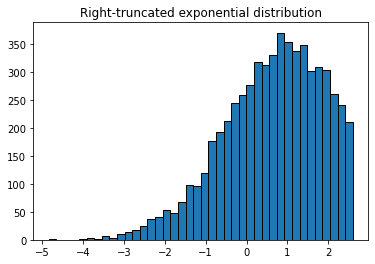

In [328]:
plt.hist(X, bins="auto", edgecolor="k")
#plt.vlines(LOC*np.ones(350), 1, np.ones(350), linestyles='--', color="darkslateblue", label="LOC")
plt.title("Right-truncated exponential distribution")
plt.show()

In [329]:
indexes = np.where(I==1)
I_cens = []
for i,j in zip(indexes[0], indexes[1]) :
    I_cens.append((i, j))

In [330]:
@jit(nopython=True)
def log_pi(phi, param, eps=0) :
    y = np.copy(param[0])
    theta = np.copy(param[1])
    mu, omega2, sigma2 = theta[:4], theta[4:8], theta[8]
    t = np.copy(param[2])
    N, K = y.shape
    log_p = 0
    inv_Omega = np.diag(1/(omega2+eps))
    for i in range(N):
        log_p -= (phi[i] - mu).T@inv_Omega@(phi[i]-mu)/2
        for j in range(K):
            log_p -= (y[i,j]-f(phi, i, t[j]))**2/(2*sigma2 + eps)

    return log_p    

In [331]:
@jit(nopython=True)
def g(phi, t) :
    return np.log10(np.exp(phi[0] - np.exp(phi[2])*t) + np.exp(phi[1] - np.exp(phi[3])*t))

In [407]:
@jit(nopython=True)
def log_pi2(phi, param, i) :
    y = np.copy(param[0])
    theta = np.copy(param[1])
    mu, omega2, sigma2 = theta[:4], theta[4:8], theta[8]
    t = np.copy(param[2])
    N, K = y.shape
    log_p = 0
    inv_Omega = np.diag(1/(omega2))
    log_p -= (phi - mu).T@inv_Omega@(phi-mu)/2
    for j in range(K):
        log_p -= (y[i,j]-g(phi, t[j]))**2/(2*sigma2)

    return log_p

In [408]:
theta_true = np.zeros(9)
theta_true[:4] = mu
theta_true[4:8] = omega2
theta_true[8] = sigma2

In [409]:
log_p = 0
i = 1
inv_Omega = np.diag(1/(omega2))
log_p -= (phi_true[i] - mu).T@inv_Omega@(phi_true[i]-mu)/2
for j in range(K):
    log_p -= (y[i,j]-f(phi_true, i, t[j]))**2/(2*sigma2)

In [410]:
log_p

-4.376605038074713

In [411]:
log_pi2(phi_true[i], param=(y, theta_true, t), i=1)

-4.376605038074713

In [337]:
@jit(nopython=True)
def log_p2(x, y, omega2, eps=0) :
    N, d = x.shape
    log_p = 0
    inv_Omega = np.diag(1/(omega2+eps))
    for i in range(N) :
        log_p-= (x[i]-y[i]).T@inv_Omega@(x[i]-y[i])/2
    return log_p

In [338]:
@jit(nopython=True)
def log_p(x, mu, omega2, eps=0) :
    N, d = x.shape
    log_p = 0
    inv_Omega = np.diag(1/(omega2+eps))
    for i in range(N) :
        log_p-= (x[i]-mu).T@inv_Omega@(x[i]-mu)/2
    return log_p

In [339]:
@jit(nopython=True)
def f(phi, i, t) :
    return np.log10(np.exp(phi[i, 0] - np.exp(phi[i, 2])*t) + np.exp(phi[i, 1] - np.exp(phi[i, 3])*t))

In [447]:
@jit(nopython=True)
def metropolis_hasting(z0, log_pi, param, mu, omega2, alpha=1, eps=0, n_iter=100) :
    z = np.copy(z0)
    N, d = z.shape
    A = []
    for n in range(n_iter) :
        y = np.zeros((N, d))
        for i in range(N) :
            for j in range(d) :
                y[i, j] = np.random.normal(loc=mu[j], scale=alpha*(np.sqrt(omega2[j])+eps))
        acc_rate = np.exp(min(0, log_pi(y, param) - log_pi(z, param) + log_p(y, mu, omega2) - log_p(z, mu, omega2)))
        u = np.random.uniform(0, 1)
        if u <= acc_rate :
            z = y
        A.append(acc_rate)
    return z, A

## Tester les 3 lois de propositions

In [420]:
@jit(nopython=True)
def log_normal(x, mean, cov) :
    inv_cov = np.diag(1/cov)
    return -(x-mean).T@inv_cov@(x-mean)/2

In [451]:
@jit(nopython=True)
def metropolis_hasting2(z0, log_pi, param, mu, omega2, alpha=1, n_iter=100) :
    z = np.copy(z0)
    N, d = z.shape
    A = []
    for n in range(n_iter) :
        for i in range(N) :
            phi_c = np.zeros(d)
            for j in range(d) :
                phi_c[j] = np.random.normal(loc=mu[j], scale=alpha*(np.sqrt(omega2[j])))
            acc_rate = np.exp(min(0, log_pi(phi_c, param, i) - log_pi(z[i], param, i) + log_normal(phi_c, mu, omega2) - log_normal(z[i], mu, omega2)))
            u = np.random.uniform(0, 1)
            if u <= acc_rate :
                z[i] = phi_c
            A.append(acc_rate)
    return z, A

In [454]:
z, A = metropolis_hasting2(np.ones((N, 4)), log_pi2, param=(y, theta_true, t), mu=mu, omega2=omega2, alpha=1, n_iter=1)

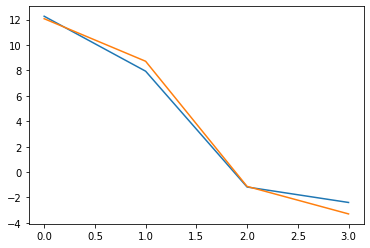

In [455]:
i = np.random.randint(0, 40)
plt.plot(z[i])
plt.plot(phi_true[i])

In [368]:
@jit(nopython=True)
def sym_metropolis_hasting(z0, log_pi, param, sigma_prop=1e-2/2, n_iter=100) :
    z = np.copy(z0)
    N, d = z.shape
    A = []
    for n in range(n_iter) :
        y = np.zeros((N, d))
        for i in range(N) :
            for j in range(d) :
                y[i, j] = np.random.normal(loc=z[i,j], scale=sigma_prop)
                
        acc_rate = np.exp(min(0, log_pi(y, param) - log_pi(z, param)))
        u = np.random.uniform(0, 1)
        if u <= acc_rate :
            z = y
        A.append(acc_rate)
    return z, A

In [369]:
theta_true = np.zeros(9)
theta_true[:4] = mu
theta_true[4:8] = omega2
theta_true[8] = sigma2

In [370]:
z, A = sym_metropolis_hasting(np.ones((N, 4)), log_pi, param=(y, theta_true, t), sigma_prop=1/2, n_iter=1)

In [371]:
A

[1.0]

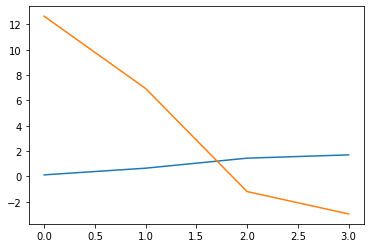

In [372]:
plt.plot(z[0])
plt.plot(phi_true[0])

In [378]:
z, A = metropolis_hasting(12*np.ones((N, 4)), log_pi, param=(y, theta_true, t), mu=theta_true[:4], omega2=theta_true[4:8], alpha=1, n_iter=100)

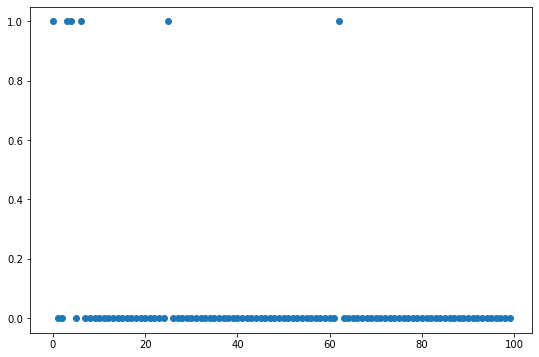

In [379]:
fig = plt.figure(figsize=(9, 6))
plt.plot(A, marker='o', ls='')
plt.show()

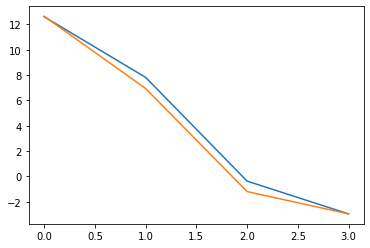

In [380]:
plt.plot(z[0])
plt.plot(phi_true[0])
plt.show()

In [456]:
#@jit(nopython=True)
def Gibbs_SAEM(theta0, y, t, I_cens, LOC, N, K, d, M1=3000, M2=1000, hm_iter=1):
    """
    SAEM algorithm implementation to find the MAP of the model    
    """
    theta = np.copy(theta0)
    Theta = np.zeros((M1+M2, 9))
    Theta[0] = theta
    Y = np.copy(y)
    Sm = np.zeros(((M1+M2), 9))
    phi = np.zeros((N, d))
    for i in range(N) :
        for j in range(d) :
            phi[i, j] = np.random.normal(loc=theta[j], scale=np.sqrt(theta[4+j]))

    #phi = np.ones_like(phi_true)
    acc_rates = []
    sm = 0
    for m in range(1, M1+M2):
        if m<=M1:
            gamma = 1
        else :
            gamma = 1/(m-M1)
        #phi, A = metropolis_hasting(phi, log_pi, param=(Y, theta, t), mu=theta[:4], omega2=theta[4:8], alpha=1.1, n_iter=hm_iter)
        phi, A = metropolis_hasting2(phi, log_pi2, param=(y, theta_true, t), omega2=theta[4:8], mu=theta[:4], alpha=1, n_iter=1)
        acc_rates += A
        #phi, _= sym_metropolis_hasting(phi, log_pi, param=(Y, theta, t), sigma_prop=1e-2/2, n_iter=hm_iter)
        #phi = ...
        # phi_c = np.zeros((N, d))
        # for i in range(N) :
        #     for j in range(d) :
        #         phi_c[i, j] = np.random.normal(loc=theta[j], scale=np.sqrt(theta[4+j]+1e-5))
        # acc_rate = np.exp(min(0, log_pi(phi_c, param=(Y, theta, t)) - log_pi(phi, param=(Y, theta, t))))
        # u = np.random.uniform(0, 1)
        # if u <= 1 : #acc_rate :
        #     phi = phi_c

        for (i,j) in I_cens :
            Y[i,j] = truncated_gaussian(f(phi, i, t[j]), np.sqrt(theta[-1]), LOC)

        sm = sm + gamma*(S(Y, phi, t) - sm)
        Sm[m] = sm
        theta[:4] = sm[:4]/N   
        theta[8] = sm[8]/(N*K)
        theta[4:8] = sm[4:8]/N - (sm[:4]**2 )/N**2
        # for i in range(N):
        #     x = phi[i, 0] - theta[0]
        #     theta[4] += x**2 / N
        #     x = phi[i, 1] - theta[1]
        #     theta[5] += x**2 / N
        #     x = phi[i, 2] - theta[2]
        #     theta[6] += x**2 / N
        #     x = phi[i, 3] - theta[3]
        #     theta[7] += x**2 / N
        
        Theta[m] = np.copy(theta)
  
    return Theta, Y, phi, acc_rates

In [457]:
theta_true

array([ 1.22000000e+01,  7.80000000e+00, -6.93147181e-01, -2.99573227e+00,
        3.00000000e-01,  3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
        4.22500000e-03])

In [478]:
theta0 =np.array([10.3, 8, -4, -2.1, 0.6, 0.6, 0.6, 0.6, 4.2*1e-3]) #theta_true # np.array([10.3, 9.8, -1.3, -2.2, 0.6, 0.6, 0.6, 0.6, 0.1]) #np.array([0, 0, 0, 0, 1, 1, 1, 1, 1]) # np.array([10, 8, -1.2, -2.1, 0.6, 0.6, 0.6, 0.6, 1]) # theta_true

In [484]:
Theta, Y, phi, acc_rates = Gibbs_SAEM(theta0, y_truncated, t, I_cens, LOC, N, K, 4, M1=3000, M2=1000, hm_iter=1)

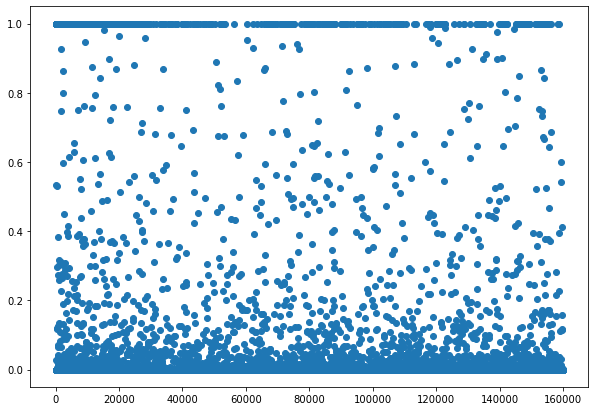

In [485]:
fig = plt.figure(figsize=(10, 7))
plt.plot(acc_rates, marker='o', ls='')
plt.show()

(0.0, 58.75)

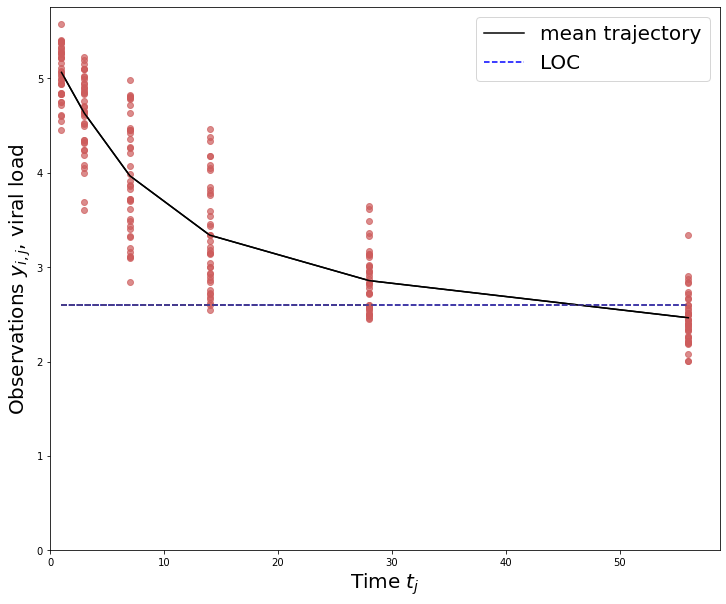

In [486]:
fig = plt.figure(figsize=(12, 10))
y_mean = Y.mean(axis=0)
y_std = Y.std(axis=0)
plt.plot(t, y_mean, "k")
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="blue", label="LOC")
for n in range(N) :
    plt.plot(t, Y[n,:], alpha=0.7, color="indianred", ls=" ", marker='o')
plt.plot(t, y_mean, "k")
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="darkslateblue", label="LOC")
# plt.fill_between(t, y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")
plt.legend(["mean trajectory", "LOC"], fontsize=20)
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$, viral load", fontsize=20)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

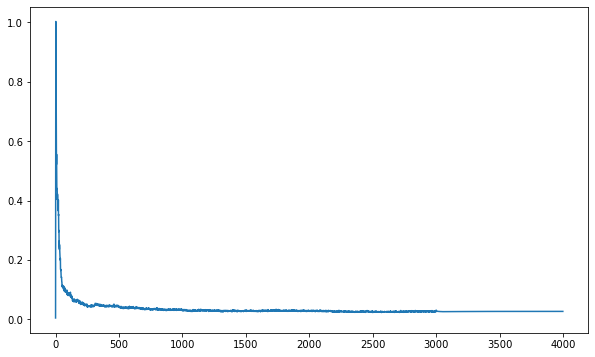

In [491]:
fig = plt.figure(figsize=(10, 6))
plt.plot(Theta[:,-1])
#plt.xscale("log")
#plt.ylim((9.8, 10.5))
plt.show()

In [398]:
Theta[-1,4]

1.0055797263080422

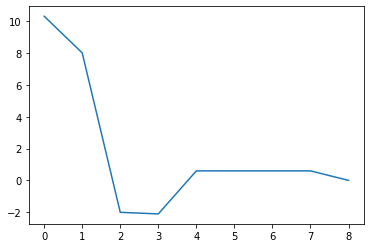

In [399]:
plt.plot(Theta[0,:])

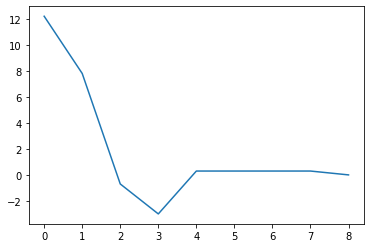

In [400]:
plt.plot(theta_true)

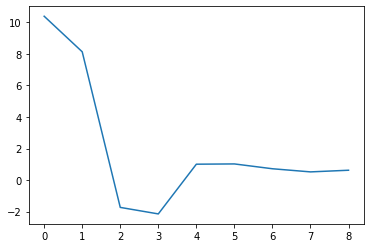

In [401]:
plt.plot(Theta[-1,:])

## Convergence empirique de l'algorithme SAEM

## Expérimenter 

D'autres lois de proposition pour le metropolis hasting.
Vérifier l'expression de la loi conditionnelle.

## Exemple jouet pour l'algorithme SAEM

On considère le modèle suivant : 

\begin{equation*}
    \begin{cases}
        \psi_i \sim \mathcal{N}(\theta, \omega²) \\
        y_i \sim \mathcal{N}(\psi_i, \sigma^2)
    \end{cases}
\end{equation*}

Seul les variables $y_i$ sont observées. 

In [396]:
N = 100
sigma2 = 0.1
omega2 = 1
theta = 10

psi = np.random.normal(theta, np.sqrt(omega2), size=N)
y = psi + np.random.normal(0, np.sqrt(sigma2), size=N)

In [397]:
def SAEM(theta0, y, k1 = 100, k2 = 100) :
    N = len(y)
    theta = theta0
    psi = np.zeros(N)
    a = 1/omega2 * (1/sigma2 + 1/omega2)**-1
    gamma2 = (1/sigma2 + 1/omega2)**-1
    Theta = np.zeros(k1+k2)
    for i in range(k1+k2) :
        if i<=k1 :
            gamma = 1
        else : 
            gamma = 1/(i-k1)
        for k in range(N) :
            psi[k] = np.random.normal(a*theta + (1-a)*y[k], np.sqrt(gamma2))
        theta = theta + gamma*(np.mean(psi)-theta)
        Theta[i] = (theta)

    return Theta

In [398]:
Theta = SAEM(theta0=-5, y=y, k1 = 200, k2 = 50)

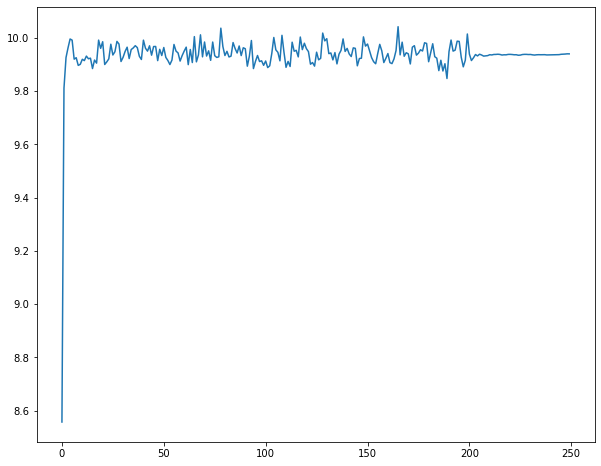

In [399]:
fg = plt.figure(figsize=(10, 8))
plt.plot(Theta)
plt.show()